In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm

from pseudobatch import pseudobatch_transform_pandas, hypothetical_concentration, metabolised_amount
from pseudobatch.datasets import load_standard_fedbatch
fedbatch_df = load_standard_fedbatch()
PAGE_WIDTH = (21 - 2.54*2)/ 2.54 # 21 cm to inch

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


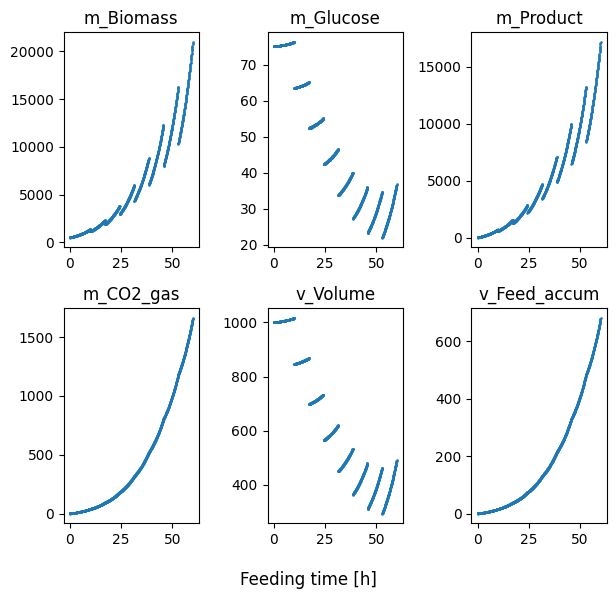

In [2]:
plot_columns = ["m_Biomass", "m_Glucose", "m_Product", "m_CO2_gas", "v_Volume", "v_Feed_accum"]

fig, axes = plt.subplots(nrows = 2, ncols = len(plot_columns) // 2, figsize=(PAGE_WIDTH, 6))
for ax, column in zip(axes.ravel(), plot_columns):
    ax.scatter(fedbatch_df["timestamp"], fedbatch_df[column], s=0.7)
    ax.title.set_text(column)
fig.supxlabel("Feeding time [h]")
fig.tight_layout()
fig.savefig("../figures/suppl_all_raw.png", dpi=300)

# Preprocessing CO2 data

In [3]:
fedbatch_df['hypothetical_c_CO2'] = hypothetical_concentration(
    metabolised_amount=fedbatch_df['m_CO2_gas'].to_numpy(),
    reactor_volume=fedbatch_df['v_Volume'].to_numpy(),
    sample_volume=fedbatch_df['sample_volume'].to_numpy()
)

In [4]:
glc_in_feed = fedbatch_df.s_f.iloc[0]
fedbatch_df[['c_Biomass_pseudo', 'c_Glucose_pseudo', 'c_Product_pseudo', 'hypothetical_c_CO2_pseudo']] =pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=['c_Biomass', 'c_Glucose', 'c_Product', 'hypothetical_c_CO2'],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0, glc_in_feed, 0, 0],
    sample_volume_colname='sample_volume',
)

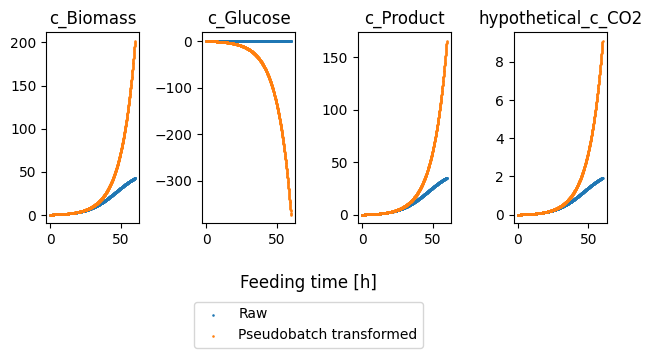

In [9]:
plot_columns = ["c_Biomass", "c_Glucose", "c_Product", "hypothetical_c_CO2"]

fig, axes = plt.subplots(nrows = 1, ncols = len(plot_columns), figsize=(PAGE_WIDTH, 3))
for ax, column in zip(axes.ravel(), plot_columns):
    ax.scatter(fedbatch_df["timestamp"], fedbatch_df[column], s=0.7)
    ax.scatter(fedbatch_df["timestamp"], fedbatch_df[column+'_pseudo'], s=0.7)
    ax.title.set_text(column)
# set global legend and place it under the figure
lgd = fig.legend(["Raw", "Pseudobatch transformed"], loc='upper center', bbox_to_anchor=(0.5, 0.0))
fig.supxlabel("Feeding time [h]")
fig.tight_layout()
fig.savefig("../figures/suppl_all_pseudobatch_transformed.png", bbox_inches='tight', dpi=300)